winter


/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


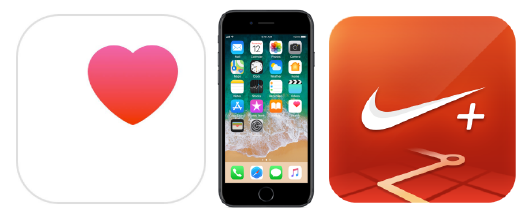

In [1]:
'__authour__ == Kanaan'

%matplotlib inline
import os,sys
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding, MDS, SpectralEmbedding
import scipy.stats as ss
import sklearn.metrics as sm
from scipy.cluster.hierarchy import inconsistent, linkage, dendrogram

sys.path.append('./')
from utils import *
from preprocess import *
from plotting import *
from cluster import *

# set some viz options
pd.options.display.max_columns=100
sns.set_style('whitegrid')

import vincent
vincent.core.initialize_notebook()
vincent.initialize_notebook()

from IPython.display import Image
Image(filename='Figs/device.png')

# Ahmad Seif Kanaan -  PrecisionRunning Project 
-  Digital Sensing Device = iPhone7-2017-09
-  Running Data    = Nike+RunClub
-  Health Data     = Apple HealthKit

#  Features
- Nike+RunClub: Distance (km)
- Nike+RunClub: Speed-Average (m/s)
- Nike+RunClub: Speed-Max (m/s)
- Nike+RunClub: Tempo (min/km)
- Nike+RunClub: Calories Burnt(kcal)
- AppleHealthKit: Mass (kg)
- AppleHealthKit: Walking+Running (km)
- AppleHealthKit: Elevation Gain (m)
- AppleHealthKit: Steps (count)
- AppleHealthKit: Sleep (hr:min:sec)

# Objectives
- Track training progress 
- Inspect improvement in total running distance and pace
- Inpsect relationship between Running (Distance,Speed) and time (month,week,day,hour) features 
- Inpsect relationship between Elevation Gain and time (month,week,day,hour) features 
- Cluster Days based on multiple-features


# Parse Sensor xml files 

In [2]:
# for extraction tools see https://github.com/amadeuskanaan/PrecisionRunning/blob/master/extract.py

# Import RAW CSVs

In [3]:
# import data 
nike_run = pd.read_csv('Data/NikeRunClub.csv', index_col = 0)
apple_WalkRun = pd.read_csv('Data/DistanceWalkingRunning.csv')
apple_BodyMass = pd.read_csv('Data/BodyMass.csv')
apple_BodyFat = pd.read_csv('Data/BodyFatPercentage.csv')
apple_steps = pd.read_csv('Data/StepCount.csv')
apple_sleep = pd.read_csv('Data/SleepAnalysis.csv')
apple_climb = pd.read_csv('Data/FlightsClimbed.csv')

# Preproces Nike+RunClub and AppleHealthKit CSVs

In [4]:
# for preprocessing tools see https://github.com/amadeuskanaan/PrecisionRunning/blob/master/preprocess.py
nike_run       = preproc_iphone_data(nike_run, 'Nike')
apple_walkrun  = preproc_iphone_data(apple_WalkRun, 'Apple')
apple_mass     = preproc_iphone_data(apple_BodyMass, 'Apple')
apple_elev     = preproc_iphone_data(apple_climb, 'Apple')
apple_steps    = preproc_iphone_data(apple_steps, 'Apple')

In [5]:
# Sum nike dataframe by Hour
nike_run_sum_hour = df_group_timefeature(nike_run, 'Time_of_day', 'sum')

# Sum nike df by weekday
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
nike_run_sum_week = df_group_timefeature(nike_run, 'Weekday', 'sum')
nike_run_sum_week = nike_run_sum_week.reindex(weekdays)

# Sum nike df by season
nike_run_sum_season = df_group_timefeature(nike_run, 'Season', 'sum')

# count nike df by weekday
nike_run_count_week = df_group_timefeature(nike_run, 'Weekday', 'count')
nike_run_count_week = nike_run_count_week.reindex(weekdays)

# Trails

/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/kanaan/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


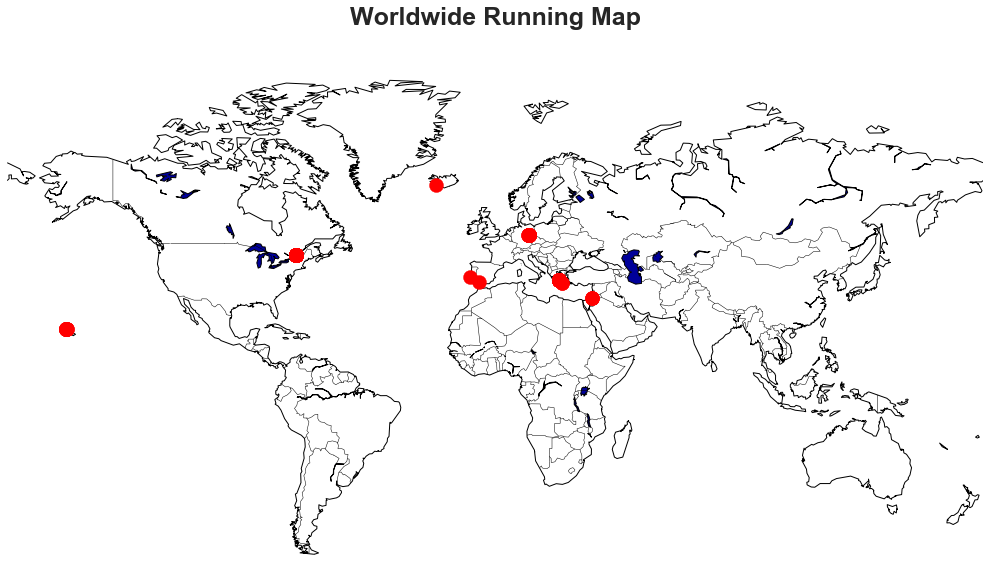

In [6]:
plt_world_map(nike_run, title = 'Worldwide Running Map')

# Running Distance

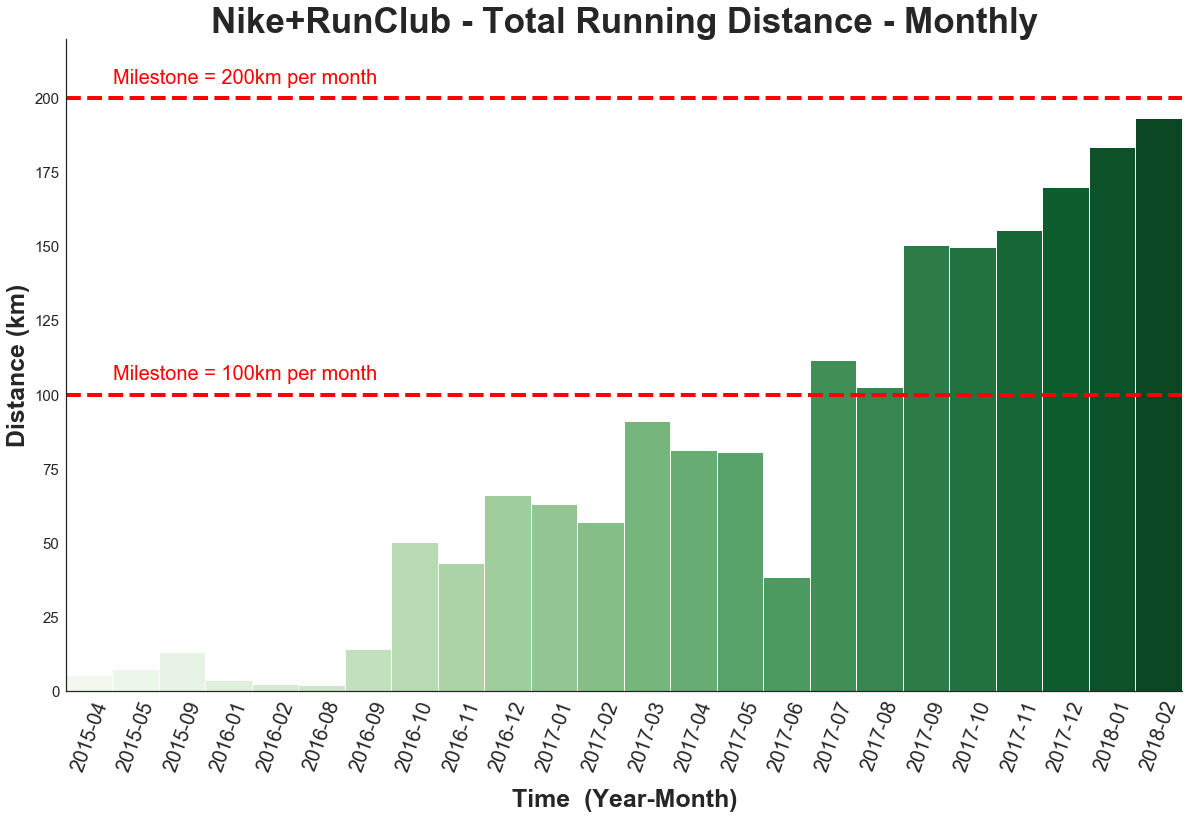

In [7]:
# Sum nike dataframe by Month
nike_run_sum_month = df_group_timefeature(nike_run, 'Month', 'sum')

# Drop years before 2015
years = ['2015','2016','2017','2018']
nike_run_sum_month = nike_run_sum_month.drop([i for i in nike_run_sum_month.index if i[0:4] not in years])

# Plot
fig, ax, g = plot_bar(df      =  nike_run_sum_month, feature = 'Distance', palette = 'Greens',
                      title   = 'Nike+RunClub - Total Running Distance - Monthly', 
                      xlabel  = 'Time  (Year-Month)', ylabel  = 'Distance (km)')
plt.ylim(0,220)
plt.axhline(100,color='r', linewidth=4, linestyle='--')
plt.axhline(200,color='r', linewidth=4, linestyle='--')
plt.annotate('Milestone = 200km per month', xy=(.5, 205), fontsize=20,color='red')
plt.annotate('Milestone = 100km per month', xy=(.5, 105), fontsize=20,color='red')

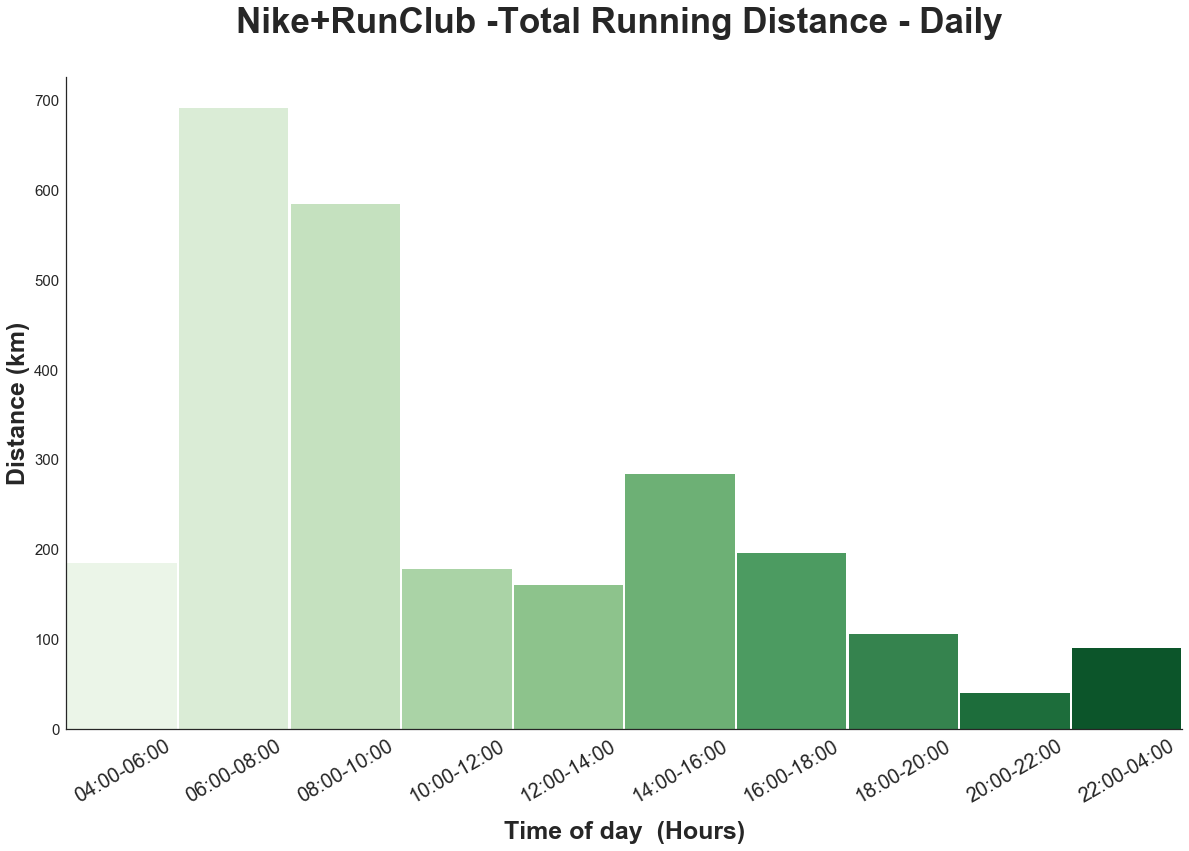

In [8]:
fig, ax, g = plot_bar(df      =  nike_run_sum_hour, 
                      feature = 'Distance', 
                      palette = 'Greens',
                      title   = 'Nike+RunClub -Total Running Distance - Daily \n', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Time of day  (Hours)', 
                      rot = 30)

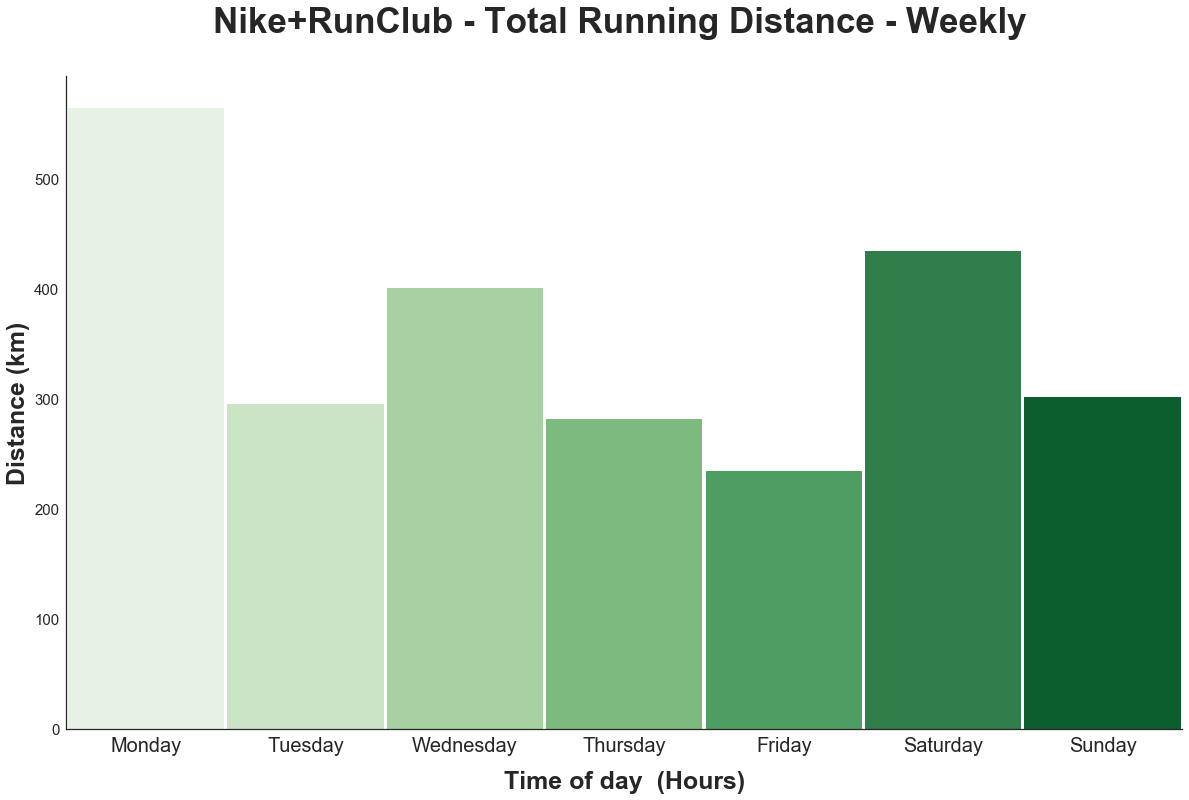

In [9]:
fig, ax, g = plot_bar(df      =  nike_run_sum_week, 
                      feature = 'Distance', 
                      palette = 'Greens',
                      title   = 'Nike+RunClub - Total Running Distance - Weekly \n', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Time of day  (Hours)',
                      rot = 0)

In [10]:
# run count per week
#pd.DataFrame(nike_run_count_week.loc[:]['Source'])

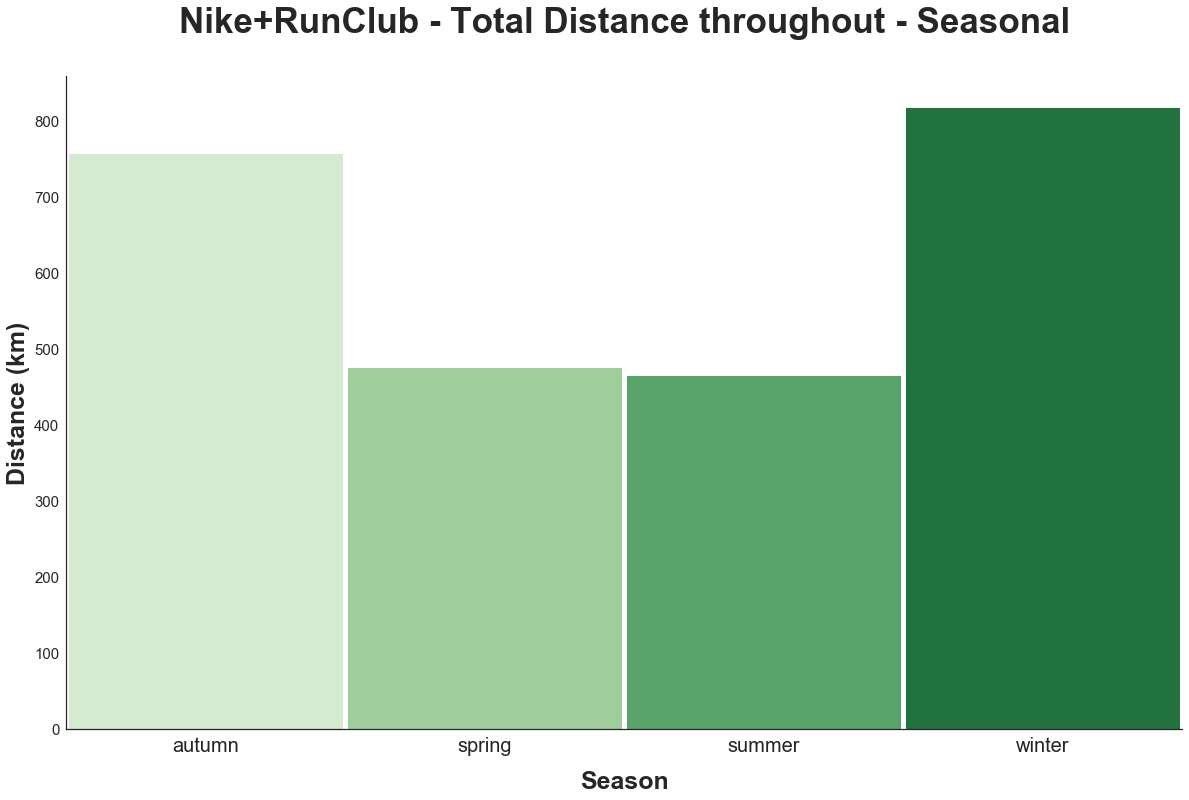

In [11]:
fig, ax, g = plot_bar(df      =  nike_run_sum_season, 
                      feature = 'Distance', 
                      palette = 'Greens',
                      title   = 'Nike+RunClub - Total Distance throughout - Seasonal\n', 
                      ylabel  = 'Distance (km)',
                      xlabel  = 'Season',
                      rot = 0)
#print 'Decieving plot ... Data includes N=2 for autumn+winter and N=1 for spring+summer'

# Average Speed

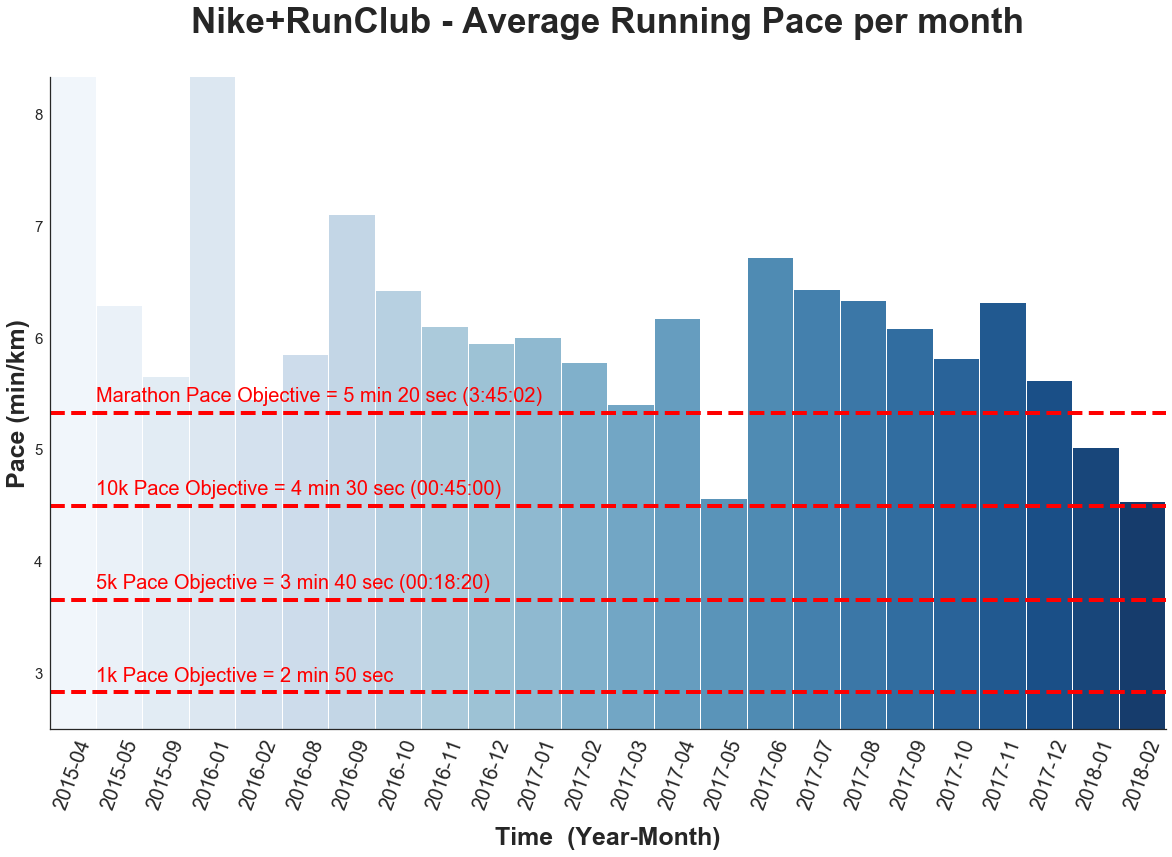

In [12]:
# Average Nike Dataframe by Month 
nike_run_avg_month = df_group_timefeature(nike_run, 'Month', 'mean')
nike_run_avg_month = nike_run_avg_month.drop([i for i in nike_run_avg_month.index if i[0:4] not in years])

# Calculate Tempo
nike_run_avg_month['Tempo'] = 1/ (nike_run_avg_month['Speed'] * (60./1000.))

fig, ax, g = plot_bar(df      =  nike_run_avg_month, feature = 'Tempo', palette = 'Blues',
                      title   = 'Nike+RunClub - Average Running Pace per month\n', 
                      ylabel  = 'Pace (min/km)',xlabel  = 'Time  (Year-Month)')

plt.ylim(2.5,8.33)
plt.axhline(2.83,color='r', linewidth=4, linestyle='--')
plt.axhline(3.66,color='r', linewidth=4, linestyle='--')
plt.axhline(4.5,color='r', linewidth=4, linestyle='--')
plt.axhline(5.33,color='r', linewidth=4, linestyle='--')
plt.annotate('1k Pace Objective = 2 min 50 sec', xy=(.5, 2.93), fontsize=20,color='red')
plt.annotate('5k Pace Objective = 3 min 40 sec (00:18:20)', xy=(.5, 3.76), fontsize=20,color='red')
plt.annotate('10k Pace Objective = 4 min 30 sec (00:45:00)', xy=(.5, 4.6), fontsize=20,color='red')
plt.annotate('Marathon Pace Objective = 5 min 20 sec (3:45:02)', xy=(.5, 5.43), fontsize=20,color='red')

# Elevation Gain 

Decieving plot..... Device doesnt measure elevetion gain accurately during indoor runs


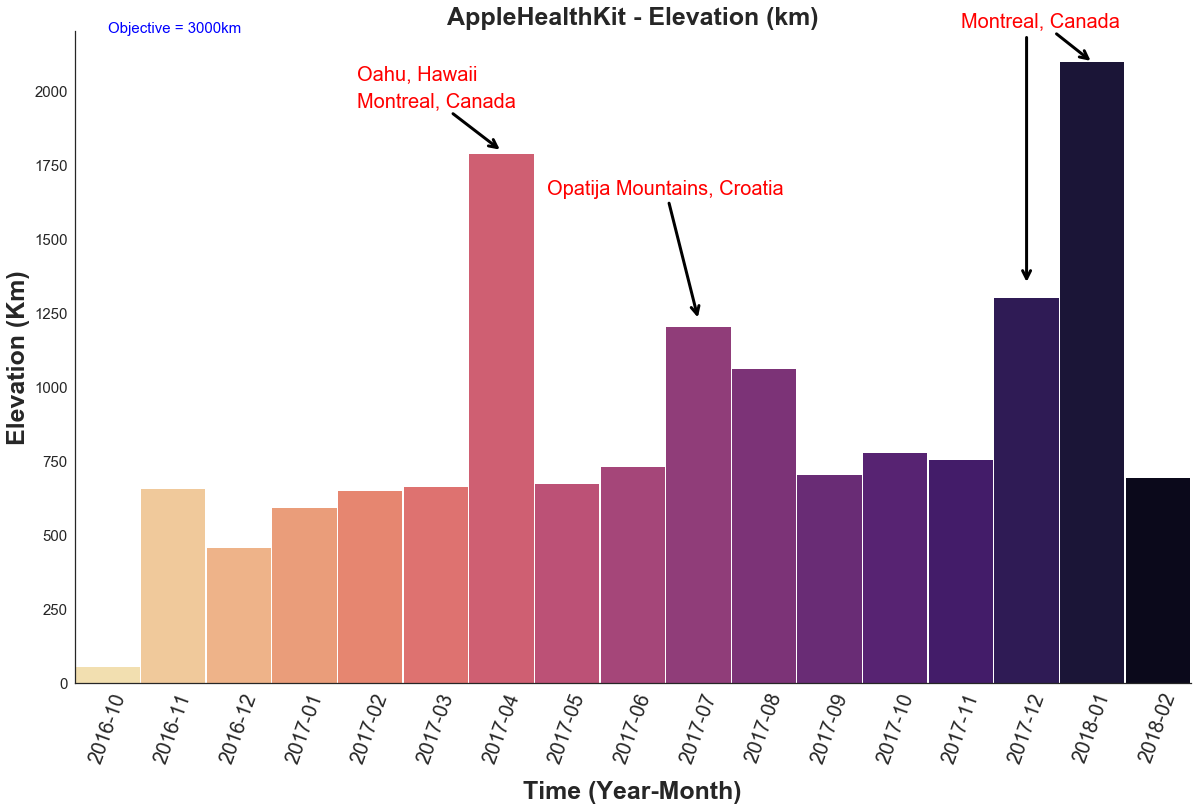

In [13]:
# Sum Elevation Dataframe by Month 
apple_elev_sum_month = df_group_timefeature(apple_elev, 'Month', 'sum')
#Convert Floors to km .... 1 Floors Climb = 3m
apple_elev_sum_month['ElevationGain'] =  apple_elev_sum_month.value*3

fig, ax, g = plot_bar(df      =  apple_elev_sum_month, feature = 'ElevationGain', palette = 'magma_r',
                      title   = 'AppleHealthKit - Elevation (m)', ylabel  = 'Elevation Gain (m)',xlabel  = 'Time  (Year-Month)')
plt.title('AppleHealthKit - Elevation (km)', fontsize=25, weight='bold')
plt.xlabel('Time (Year-Month)', fontsize=25, labelpad=15, weight='bold')
plt.ylabel('Elevation (Km)', fontsize=25, weight='bold')
plt.annotate('Montreal, Canada', xy=(6, 600*3), xytext=(3.8, 650*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Oahu, Hawaii', xy=(6, 630*3), xytext=(3.8, 680*3), fontsize=20,color='red')
plt.annotate('Opatija Mountains, Croatia', xy=(9, 410*3), xytext=(6.7, 550*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Montreal, Canada', xy=(15, 700*3), xytext=(13, 740*3),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('', xy=(14, 450*3), xytext=(14, 730*3), arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=20,color='red')
plt.annotate('Objective = 3000km', xy=(.01, 2000), xytext=(.01, 2200), fontsize=15,color='blue')

print 'Decieving plot..... Device doesnt measure elevetion gain accurately during indoor runs'

# Mass 

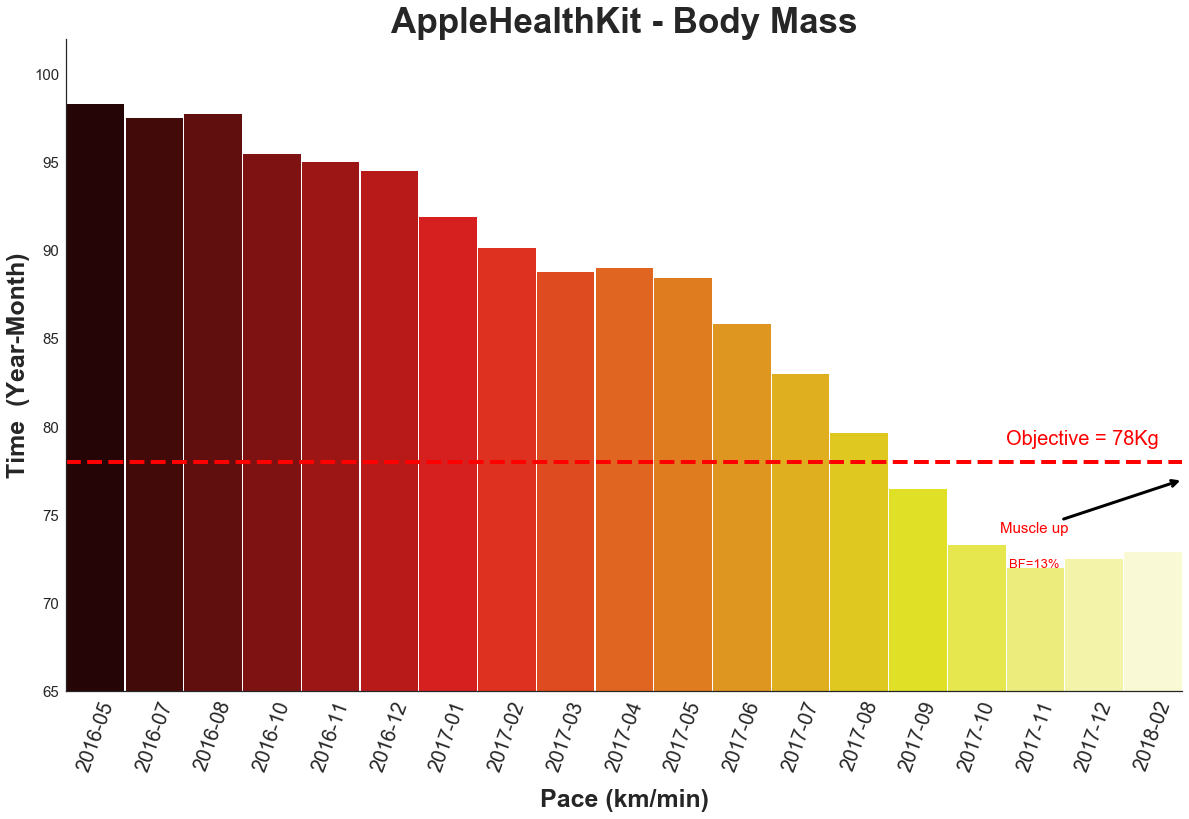

In [14]:
apple_mass_avg_month = df_group_timefeature(apple_mass, 'Month', 'mean')
fig, ax, g = plot_bar(df      =  apple_mass_avg_month, feature = 'value', palette = 'hot', 
                      title   = 'AppleHealthKit - Body Mass', xlabel  = 'Pace (km/min)', 
                      ylabel  = 'Time  (Year-Month)')

plt.ylim(65,102)
plt.axhline(78,color='r', linewidth=4, linestyle='--')
plt.annotate('Objective = 78Kg', xy=(15.5, 79), fontsize=20,color='red')
plt.annotate('Muscle up', xy=(18.5, 77), xytext=(15.4, 74),arrowprops=dict(arrowstyle="->", facecolor='red', lw=3), fontsize=15,color='red')
plt.annotate('BF=13%', xy=(15.55, 72), fontsize=13,color='red')

# Step Count

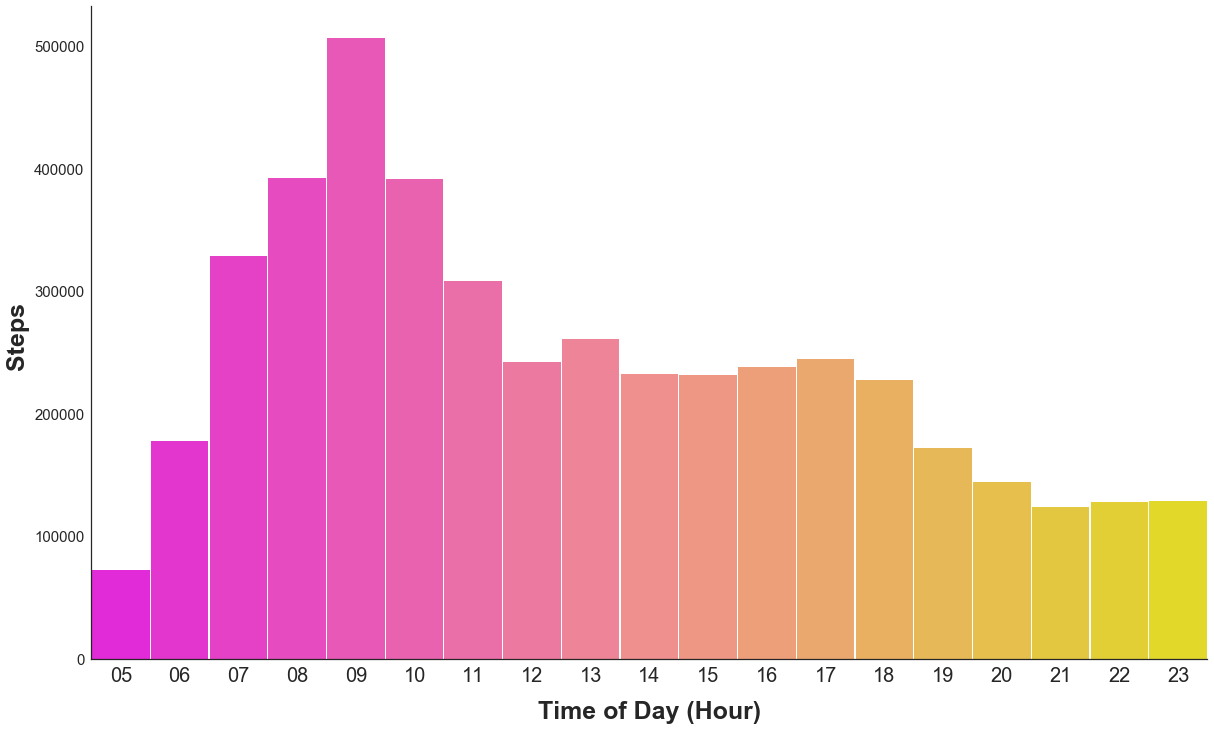

In [15]:
apple_steps_sum_hour = df_group_timefeature(apple_steps, 'Time_of_day_val', 'sum')
fig, ax, g = plot_bar(df      =  apple_steps_sum_hour[5:], 
                      feature = 'value', 
                      palette = 'spring',
                      title   = '', 
                      ylabel  = 'Steps ',
                      xlabel  = 'Time of Day (Hour)',
                      rot = 0)

# Feature Data Clustering  .

- Nike  - Total Running Distance
- Nike  - Average Running Speed
- Apple - Walk+Run Distance
- Apple - Elevation Gain
- Apple - Step Count

# Lets preprocess first 

In [16]:
# Preprocess Features of Interest
### Create two conctenated dataframes. 
#### 1- All Days 
#### 2- Running days only

apple_walkrun_day  = df_group_timefeature(apple_walkrun, 'Day', 'sum', feature_name='WalkRun')
apple_elev_day     = df_group_timefeature(apple_elev, 'Day', 'sum', feature_name='ElevationGain')
apple_steps_day    = df_group_timefeature(apple_steps, 'Day', 'sum', feature_name='StepCount')

nike_run_day_sum   = df_group_timefeature(nike_run, 'Day','sum')
nike_run_day_avg   = df_group_timefeature(nike_run, 'Day','mean')
years = ['2016','2017','2018','2019']
nike_run_day_sum   = nike_run_day_sum.drop([i for i in nike_run_day_sum.index if i[0:4] not in years])
nike_run_day_avg   = nike_run_day_avg.drop([i for i in nike_run_day_avg.index if i[0:4] not in years])

# Concatenate Dataframes
df_features_day       = pd.concat([nike_run_day_sum, apple_walkrun_day, apple_elev_day, apple_steps_day ], axis = 1)#.sort_index()

# Keep features only 
features = ['Distance', 'Speed', 'ElevationGain','WalkRun', 'StepCount']
drop_col = [i for i in df_features_day.columns if i not in features]
df_features_day = df_features_day.drop(drop_col,axis=1)[9:]

# breakdown dataframes into (a) all-days, (b) walk days, (c) run days
df_features_day_all  = df_features_day.fillna(0)

running_days = [i for i in df_features_day_all.index if df_features_day_all.loc[i]['Speed'] != 0.]
walking_days = [i for i in df_features_day_all.index if df_features_day_all.loc[i]['Speed'] == 0.]
df_features_day_run = df_features_day_all.drop(walking_days)
df_features_day_wlk = df_features_day_all.drop(running_days)

# Normalize features by column 
df_features_day_all_z  = normalize_df_bycol(df_features_day_all)
df_features_day_run_z  = normalize_df_bycol(df_features_day_run)

# Relationship between features 

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

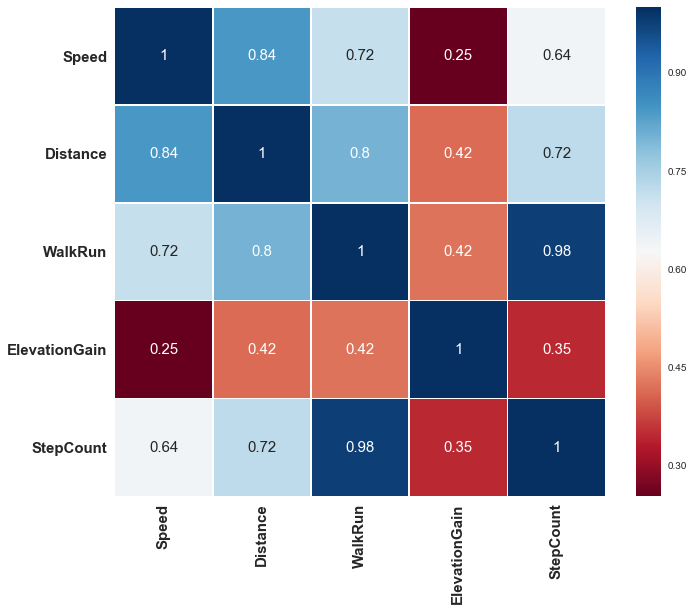

In [17]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_features_day_all_z.corr(), cmap='RdBu', linewidths=.5, cbar_kws={"shrink": 1}, 
            ax=ax, annot = True, annot_kws={"size":15})

plt.xticks(fontsize = 15, weight='bold', rotation=90)
plt.yticks(fontsize = 15, weight='bold', rotation=0)

# Agglomerative Clustering
## All Days

Total Number of Days= 488


/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


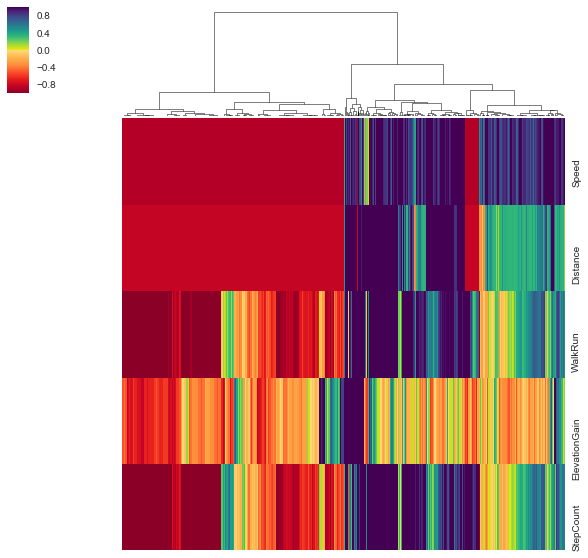

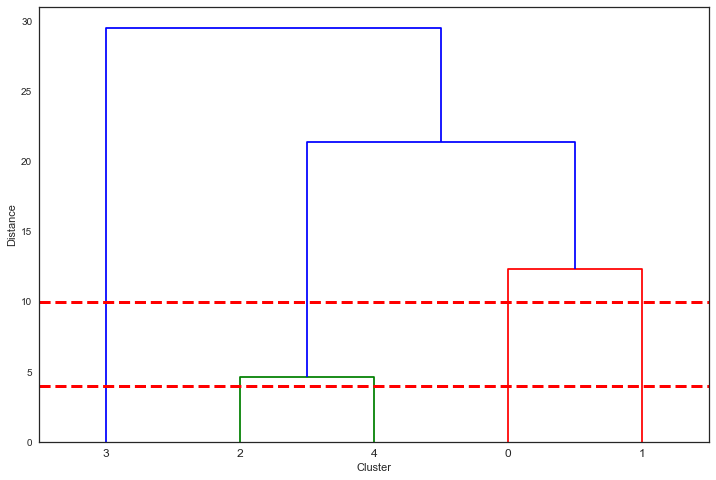

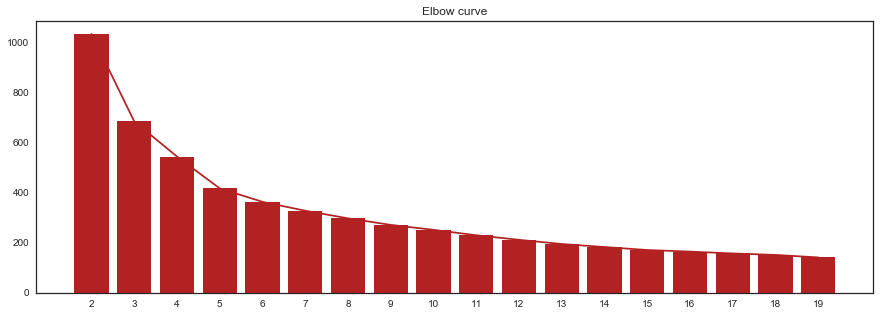

In [18]:
print 'Total Number of Days=', len(df_features_day_all_z) 

df_cluster = sns.clustermap(df_features_day_all_z.T, xticklabels=False, yticklabels=True, 
                         cmap = cmap_gradient, row_cluster= False, vmin = -1, vmax = 1, 
                            method = 'ward', metric ='euclidean',  )

plot_dendogram(df_features_day_all_z.T, method='ward', metric='euclidean') 
       
plot_elbow(df_features_day_all_z)

In [19]:
# Agglomerative Clustering
## Runnning Days

Total Number of RUNNING Days= 226


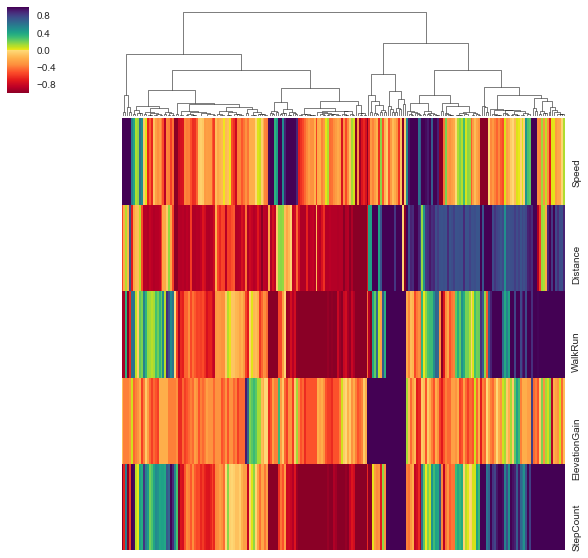

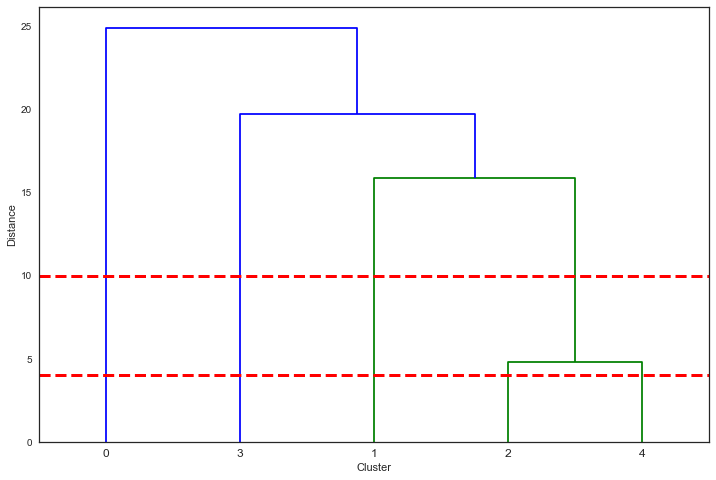

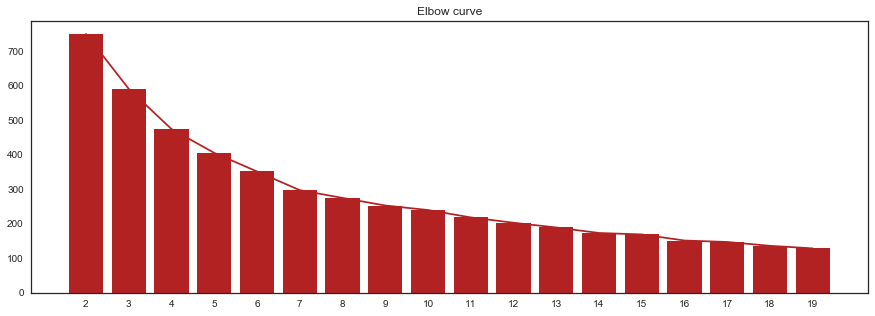

In [20]:
print 'Total Number of RUNNING Days=', len(df_features_day_run_z) 
df_cluster = sns.clustermap(df_features_day_run_z.T, xticklabels=False, yticklabels=True, 
                         cmap = cmap_gradient, row_cluster= False, vmin = -1, vmax = 1, 
                            method = 'ward', metric ='euclidean',  )

plot_dendogram(df_features_day_run_z.T, method='ward', metric='euclidean') 
plot_elbow(df_features_day_run_z)

# Inspect cluster structure in low-dimentional embedding space 
- Apply Manifold learning for non-linear dimensionality reduction
- Methods include: isomap, tsne , mds, spectral, lle, kpca, pca

(488, 3)


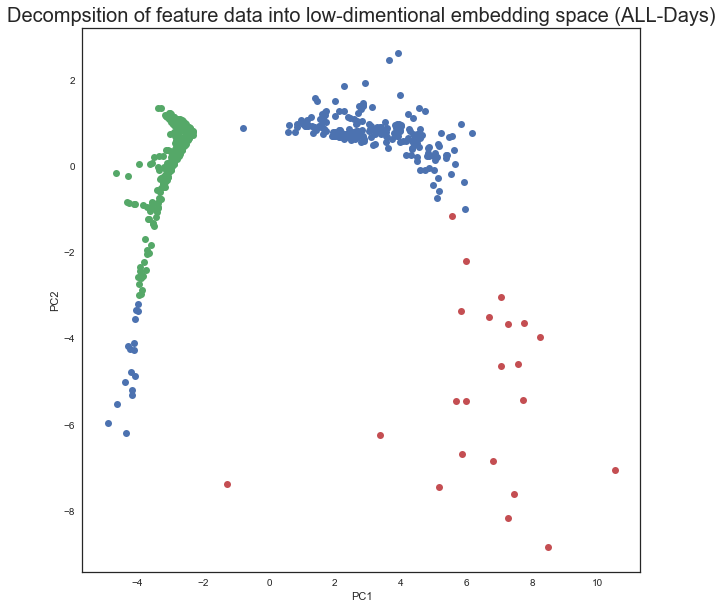

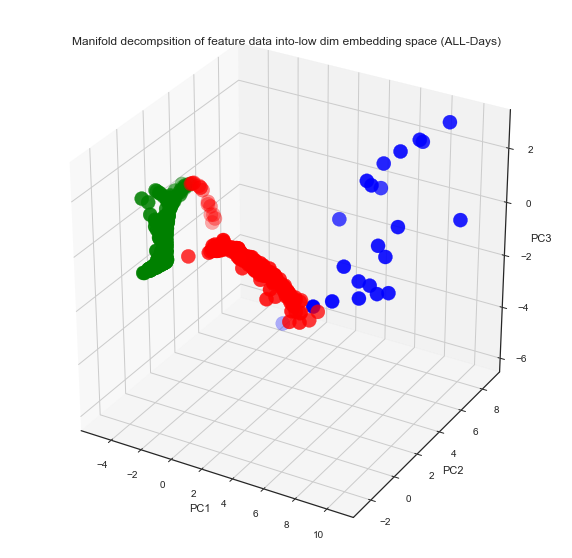

In [21]:
manifold_method = 'isomap'
lle_method='modified'

plot_cluster_components(df_features_day_all_z ,decomposition =  manifold_method, lle_method = lle_method, plot='2D', 
                        titlex ='Decompsition of feature data into low-dimentional embedding space (ALL-Days)')
plot_cluster_components(df_features_day_all_z ,decomposition =  manifold_method, lle_method = lle_method, plot='3D', 
                        titlex ='Manifold decompsition of feature data into-low dim embedding space (ALL-Days)')

(226, 3)


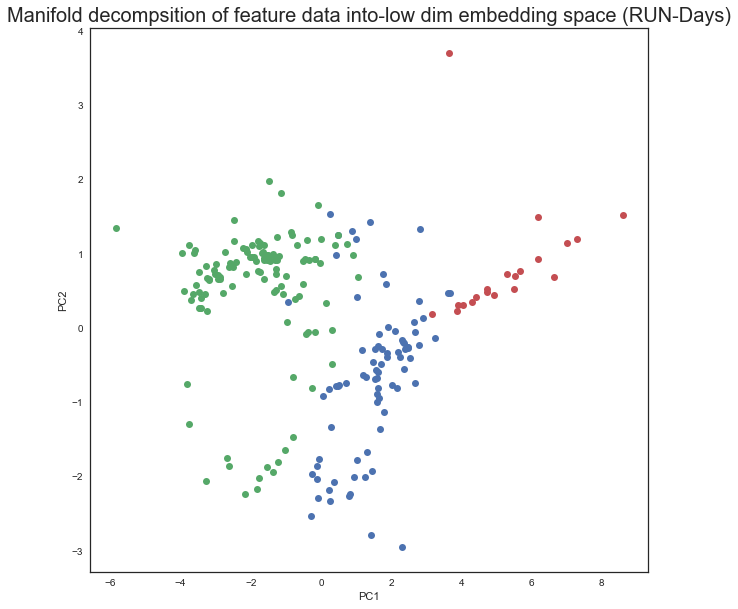

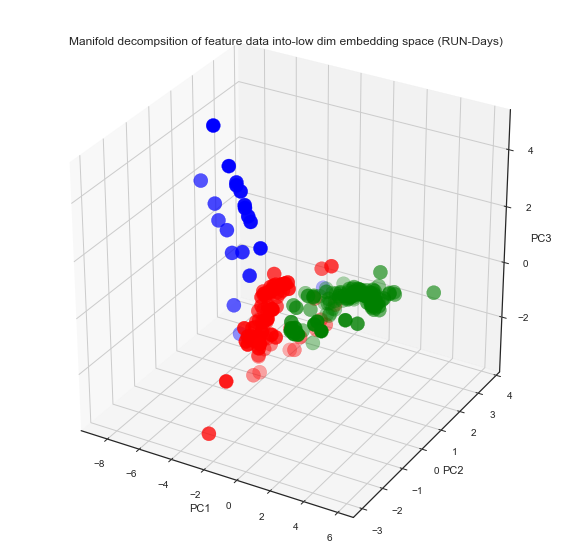

In [22]:
plot_cluster_components(df_features_day_run_z , manifold_method, lle_method, plot='2D', n_clusters=4,
                       titlex ='Manifold decompsition of feature data into-low dim embedding space (RUN-Days)')

plot_cluster_components(df_features_day_run_z , manifold_method, lle_method, plot='3D', n_clusters=4,
                       titlex ='Manifold decompsition of feature data into-low dim embedding space (RUN-Days)')

# Feature differences for the different day clusters 

In [23]:
n_clusters  = 4
features = ['Distance', 'Speed', 'ElevationGain','WalkRun', 'StepCount']

# #####################################################################'
## ALL-DAYS ----- Clustering indicates data broken down into groups with: 
    - (a) Very Active days (with Runs) 
    - (b) Normal Active days - No Running+GoodMovement
    - (c) Sedentary days

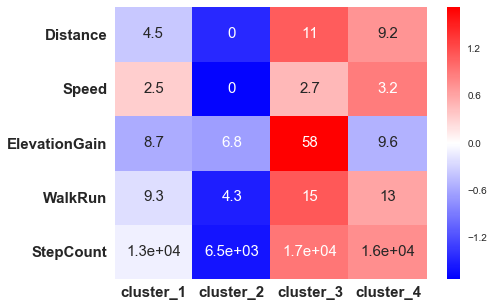

In [24]:
clust_all, clust_allL,clust_allZ = return_cluster_dfs(df_features_day_all, df_features_day_all_z, n_clusters, features)
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(normalize_df_bycol(clust_all.fillna(0)).T, annot=clust_all.T, cmap='bwr',  annot_kws={"size":15})
plt.xticks(fontsize = 15, weight='bold'), plt.yticks(fontsize = 15, weight='bold')
plt.show()

# #####################################################################'
### Indicates that RUNNING days are broken down into 
    - (a) Recovery Runs  ----- Short Distance (5Km), Low ElevationGain, 5.3 min pace
    - (b) Distance Runs  ----- Medium Distance (10Km+), Low Elevation,  5.3 min pace
    - (c) Mountain Runs with speed ----- Medium Distance (10Km+), High-elevation, 6.2min pace

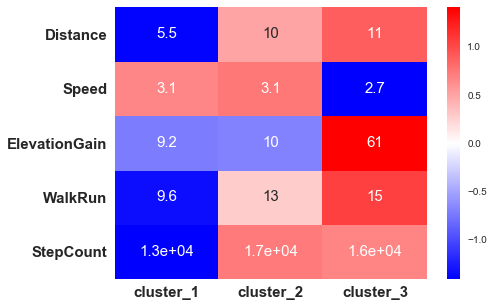

In [25]:
n_clusters  = 3
clust_run ,clust_runL,clust_runZ = return_cluster_dfs(df_features_day_run, df_features_day_run_z, n_clusters, features)

f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(normalize_df_bycol(clust_run.fillna(0)).T, annot=clust_run.T, cmap='bwr',  annot_kws={"size":15})
plt.xticks(fontsize = 15, weight='bold'), plt.yticks(fontsize = 15, weight='bold')
plt.show()

# Day count per Cluster

In [26]:
clust_runL.groupby('label').count()

,Speed,Distance,WalkRun,ElevationGain,StepCount
label,,,,,
0,125,125,125,125,125
1,81,81,81,81,81
2,20,20,20,20,20


In [27]:
clust_allL.groupby('label').count()

,Speed,Distance,WalkRun,ElevationGain,StepCount
label,,,,,
0,110,110,110,110,110
1,245,245,245,245,245
2,22,22,22,22,22
3,111,111,111,111,111


(array([ 3.,  7., 11., 15., 20., 24., 28., 33., 37., 42., 46., 50.]),
 <a list of 12 Text xticklabel objects>)

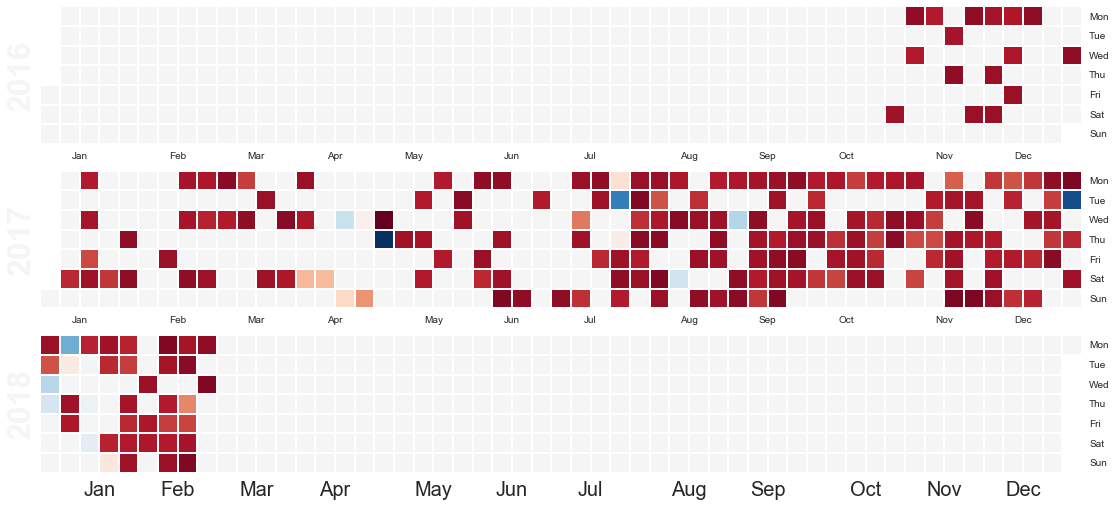

In [121]:
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap


calmap.calendarplot(pd.Series(df_features_day_run_z.ElevationGain.values, 
                index=[datetime.datetime.strptime(i,'%Y-%m-%d') for i in df_features_day_run.index]), 
                cmap='RdBu',
                fig_kws=dict(figsize=(20,7)))

plt.xticks(fontsize=20)

(<matplotlib.figure.Figure at 0x129b6a210>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1299a3190>,
       dtype=object))

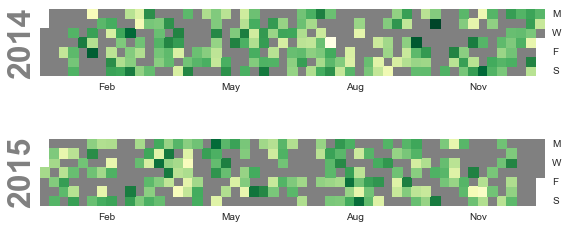

In [97]:
f = plt.figure(figsize=(30,30))
calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(8, 4)))

In [47]:
pd.Series(df_features_day_run.Distance)

2016-10-29    11.029730
2016-10-31     7.381700
2016-11-02     5.488340
2016-11-07     5.230000
2016-11-15     5.900740
2016-11-17     5.733200
2016-11-21     5.196410
2016-11-26    10.037000
2016-11-28     5.522700
2016-12-01    10.423880
2016-12-03    10.022980
2016-12-05    10.096530
2016-12-07    10.241700
2016-12-09    10.000000
2016-12-12    10.054000
2016-12-28     5.047840
2017-01-07    10.072670
2017-01-09    10.028340
2017-01-11     5.087600
2017-01-13    10.262070
2017-01-14     7.069120
2017-01-21    10.119190
2017-01-26     5.051340
2017-01-28     5.067450
2017-02-10     5.351320
2017-02-13    10.025870
2017-02-15     5.018210
2017-02-18     5.047190
2017-02-20     5.088990
2017-02-22     6.057735
                ...    
2018-01-16     9.000000
2018-01-18    14.000000
2018-01-20     9.000000
2018-01-22     7.541720
2018-01-23     8.189560
2018-01-27    10.099420
2018-01-28    12.000000
2018-01-29     9.198620
2018-01-30    12.343680
2018-02-01     7.181610
2018-02-02    10

In [34]:
events

2015-12-11   -0.998662
2014-06-17   -0.136021
2014-11-04   -0.240216
2014-02-07    0.217959
2014-05-05   -0.188949
2014-05-21   -0.171695
2014-12-11   -0.143083
2014-04-11   -1.030827
2014-03-27    0.605146
2015-06-13    0.162624
2015-08-14    2.445115
2015-02-03    1.192440
2014-10-10    0.751080
2015-04-11   -2.816624
2015-09-18   -1.545717
2014-07-05   -0.378677
2014-07-04    1.201337
2014-09-25   -0.472154
2015-10-29   -2.032129
2014-07-31   -2.532981
2014-02-26    0.872134
2014-09-23   -1.356469
2014-12-27    1.824630
2015-08-16    0.876438
2014-08-03    1.516988
2015-06-22    0.050273
2015-04-14   -1.985682
2015-10-04    0.260657
2014-02-21   -1.233212
2014-04-09    1.842133
                ...   
2015-11-14   -2.708853
2015-05-22    0.148180
2014-03-09    1.034055
2014-08-20    0.242292
2015-06-08   -0.712761
2014-08-16   -0.104190
2015-05-11    0.430522
2015-08-25    0.538674
2014-04-10   -0.029848
2015-11-30    0.105490
2014-07-20   -0.049128
2015-05-10   -2.291897
2015-08-28 